In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/protein_data.csv')
data.head()

,sequence,classification
0,AQLVDSMPSASTGSVVVTDDLNYWGGRRIKSKDGATTEPVFEPATG...,OXIDOREDUCTASE
1,MGAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGL...,HYDROLASE
2,STAGKVIKCKAAVLWEEKKPFSIEEVEVAPPKAHEVRIKMVATGIC...,OXIDOREDUCTASE
3,MDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQNANP...,VIRAL PROTEIN
4,EVKQENRLLNESESSSQGLLGYYFSDLNFQAPMVVTSSTTGDLSIP...,TOXIN


In [3]:
X = data['sequence']
y = data['classification']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
class_names = le.classes_
n_classes = len(class_names)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [4]:
avg_char_len = X_train.str.len().mean()
print(f"Average character length: {avg_char_len:.2f}")

Average character length: 241.89


In [5]:
import torch

aa_to_idx = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5,
    'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
    'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15,
    'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20,
    'B': 0, 'Z': 0, 'U': 0, 'O': 0, 'X': 0
}

def encode_sequence(seq, max_len=250):
    encoded = [aa_to_idx.get(aa, 0) for aa in seq]  # map or 0 if unknown
    if len(encoded) < max_len:
        encoded += [0] * (max_len - len(encoded))  # zero padding
    else:
        encoded = encoded[:max_len]  # truncate if longer
    return torch.tensor(encoded, dtype=torch.long)

In [6]:
print(X_train[0])
embedding = torch.nn.Embedding(num_embeddings=21, embedding_dim=128, padding_idx=0)
embedding(encode_sequence(X_train[0]))

AQLVDSMPSASTGSVVVTDDLNYWGGRRIKSKDGATTEPVFEPATGRVLCQMVPCGAEEVDQAVQSAQAAYLKWSKMAGIERSRVMLEAARIIRERRDNIAKLEVINNGKTITEAEYDIDAAWQCIEYYAGLAPTLSGQHIQLPGGAFAYTRREPLGVCAGILAWNYPFMIAAWKCAPALACGNAVVFKPSPMTPVTGVILAEIFHEAGVPVGLVNVVQGGAETGSLLCHHPNVAKVSFTGSVPTGKKVMEMSAKTVKHVTLELGGKSPLLIFKDCELENAVRGALMANFLTQGQVCTNGTRVFVQREIMPQFLEEVVKRTKAIVVGDPLLTETRMGGLISKPQLDKVLGFVAQAKKEGARVLCGGEPLTPSDPKLKNGYFMSPCVLDNCRDDMTCVKEEIFGPVMSVLPFDTEEEVLQRANNTTFGLASGVFTRDISRAHRVAANLEAGTCYINTYSISPVEVPFGGYKMSGFGRENGQATVDYYSQLKTVIVEMGDVDSLF


tensor([[-1.5188,  0.4630, -0.2499,  ..., -0.9866, -0.8962, -0.1694],
        [ 3.0729,  2.1790, -0.8209,  ...,  0.0910, -1.1922,  1.1350],
        [-0.7756,  0.7830,  1.1722,  ..., -0.0884, -1.1325, -0.0227],
        ...,
        [ 0.3049,  0.0071,  0.0157,  ..., -0.0158,  0.3441,  0.9420],
        [ 0.3836,  0.0088, -0.2614,  ..., -0.3243,  0.8638, -0.1622],
        [-0.0631,  1.3589,  0.1812,  ..., -2.9769, -1.1891, -0.3656]],
       grad_fn=<EmbeddingBackward0>)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader


class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq = pd.Series(self.X).iloc[idx]
        label = pd.Series(self.y).iloc[idx]
        encoded_seq = encode_sequence(seq)
        return encoded_seq, torch.tensor(label, dtype=torch.long)

In [8]:
train_dataset = ProteinDataset(X_train, y_train)
val_dataset   = ProteinDataset(X_val, y_val)
test_dataset  = ProteinDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_classes, pad_idx=0):
        super(RNNClassifier, self).__init__()

        # Embedding for protein sequences
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # Simple RNN (can be bidirectional if you want)
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, 256)   # *2 because bidirectional
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, n_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x: [batch_size, seq_len]
        x = self.embedding(x)                     # -> [batch_size, seq_len, embedding_dim]
        output, h = self.rnn(x)                   # h: [num_layers * num_directions, batch_size, hidden_dim]

        # Concatenate last hidden states from forward & backward RNN
        if self.rnn.bidirectional:
            h = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        else:
            h = h[-1,:,:]

        # Classifier head
        x = self.relu(self.fc1(h))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc_out(x)

        return x

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

def train_model(model, train_loader, val_loader, n_epochs=20, lr=1e-3, patience=3):
    global history
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    patience_counter = 0
    best_model_wts = None

    for epoch in range(n_epochs):
        epoch_start = time.time()
        
        # --- Train ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        train_loss /= total

        # --- Validation ---
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)

                val_loss += loss.item() * X.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        val_loss /= total

        # --- Save history ---
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start

        print(f"Epoch {epoch+1}: "
              f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Val loss={val_loss:.4f}, acc={val_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        # --- Early Stopping ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                if best_model_wts is not None:
                    model.load_state_dict(best_model_wts)
                break

    return model

In [10]:
vocab_size = 21
embedding_dim = 128
hidden_dim = 128

model = RNNClassifier(vocab_size, embedding_dim, hidden_dim, n_classes)
trained_model = train_model(model, train_loader, val_loader, n_epochs=20, lr=1e-3, patience=3)

Epoch 1: Train loss=3.0289, acc=0.1699 | Val loss=2.6899, acc=0.2601 | Time: 31.01s
Epoch 2: Train loss=2.6526, acc=0.2676 | Val loss=2.4000, acc=0.3363 | Time: 30.59s
Epoch 3: Train loss=2.4655, acc=0.3156 | Val loss=2.2573, acc=0.3743 | Time: 30.37s
Epoch 4: Train loss=2.3881, acc=0.3361 | Val loss=2.2347, acc=0.3820 | Time: 30.42s
Epoch 5: Train loss=2.3299, acc=0.3523 | Val loss=2.1663, acc=0.4036 | Time: 30.38s
Epoch 6: Train loss=2.3118, acc=0.3587 | Val loss=2.1431, acc=0.4084 | Time: 30.50s
Epoch 7: Train loss=2.2891, acc=0.3654 | Val loss=2.1111, acc=0.4201 | Time: 30.43s
Epoch 8: Train loss=2.3012, acc=0.3628 | Val loss=2.0957, acc=0.4258 | Time: 30.34s
Epoch 9: Train loss=2.3231, acc=0.3600 | Val loss=2.1364, acc=0.4163 | Time: 30.41s
Epoch 10: Train loss=2.3023, acc=0.3642 | Val loss=2.1162, acc=0.4176 | Time: 30.42s
Epoch 11: Train loss=2.2602, acc=0.3742 | Val loss=2.0612, acc=0.4352 | Time: 30.45s
Epoch 12: Train loss=2.2693, acc=0.3728 | Val loss=2.1091, acc=0.4230 | Ti

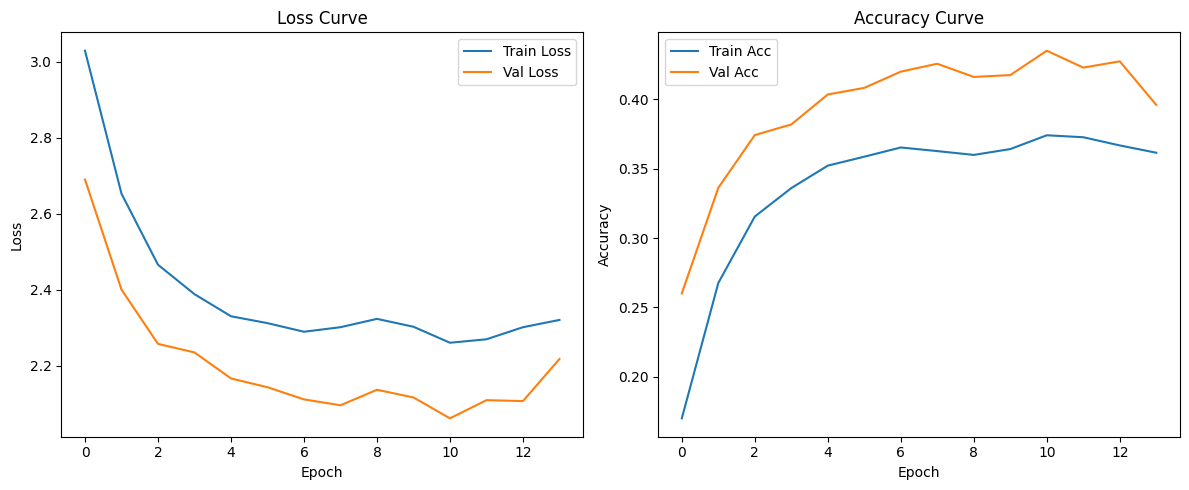

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Loss subplot ---
axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_title("Loss Curve")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# --- Accuracy subplot ---
axes[1].plot(history["train_acc"], label="Train Acc")
axes[1].plot(history["val_acc"], label="Val Acc")
axes[1].set_title("Accuracy Curve")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


In [12]:
import torch
import time

def get_predictions(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return all_preds, all_labels

y_pred, y_true = get_predictions(trained_model, test_loader)

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
accuracy_score(y_true, y_pred)

0.3939058376243471

In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.38      0.37      1708
           1       0.38      0.53      0.44      1685
           2       0.47      0.38      0.42      1729
           3       0.61      0.79      0.69      1682
           4       0.27      0.28      0.28      1705
           5       0.52      0.54      0.53      1628
           6       0.53      0.85      0.66      1646
           7       0.28      0.07      0.12      1783
           8       0.37      0.34      0.35      1661
           9       0.39      0.50      0.44      1685
          10       0.36      0.35      0.36      1683
          11       0.35      0.25      0.29      1679
          12       0.27      0.28      0.28      1728
          13       0.54      0.36      0.43      1687
          14       0.43      0.31      0.36      1686
          15       0.26      0.04      0.08      1633
          16       0.74      0.95      0.83      1699
          17       0.50    

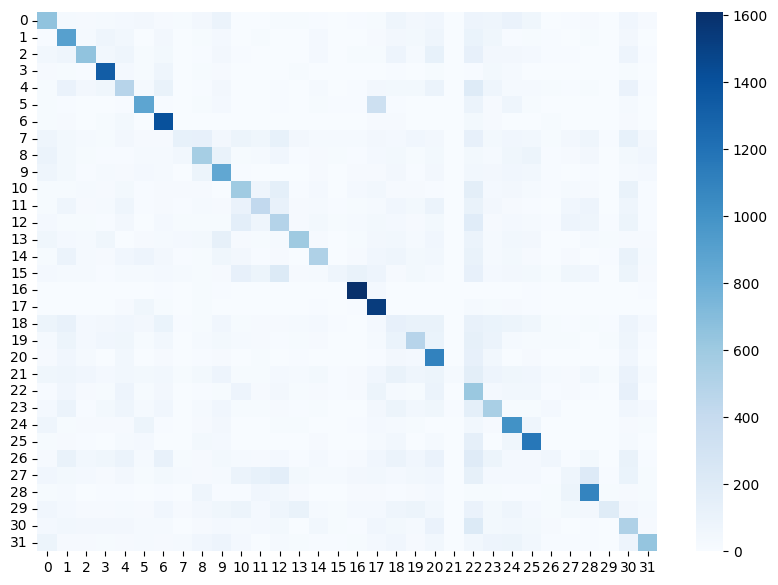

In [16]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap='Blues');

In [17]:
torch.save(model.state_dict(), "./models/rnn_model_weights.pth")

In [18]:
torch.save(model, "./models/rnn_model_full.pth")

In [19]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("./models/rnn_model_full.pth", map_location=device, weights_only=False)
model.to(device)
model.eval()

RNNClassifier(
  (embedding): Embedding(21, 128, padding_idx=0)
  (rnn): RNN(128, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [21]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.3939
Precision: 0.3884
Recall: 0.3939
F1 Score: 0.3646
